In [1]:
import numpy as np
import seaborn as sns
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
%matplotlib inline
import sklearn
import sklearn.preprocessing

import matplotlib
import matplotlib.pyplot as plt

import pickle
import random
import time
import webbrowser

In [2]:
# twitter dataset

with open("ovchinnikov-rutwitterdataset/A.pkl", "rb") as file:
    A = np.load(file, encoding="latin1")

with open("ovchinnikov-rutwitterdataset/labeled_nodes.pkl", "rb") as file:
    labels = np.load(file, encoding="latin1")

with open("ovchinnikov-rutwitterdataset/i2t.pkl", "rb") as file:
    i2t = pickle.load(file)

with open("ovchinnikov-rutwitterdataset/t2i.pkl", "rb") as file:
    t2i = pickle.load(file)

In [3]:
# preprocessing

F = sklearn.preprocessing.normalize(A, axis=1, norm='l1')
B = sklearn.preprocessing.normalize(A.T, axis=1, norm='l1')
d = np.array(labels.todense())[:, 0]

/Users/ko/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int8 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
/Users/ko/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int8 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [4]:
# we are looking for solution x == T(x)

def T(F, B, d, x, a1=0.7, a2=0.7, a3=0.7):
    return a1 * F.dot(x.clip(0)) + a2 * B.dot(x.clip(-np.inf, 0)) + a3 * d

In [5]:
# original RepRank

def RepRank(F, B, d, maxiter=200, x0=None, tol=1e-8, callback=None):
    if x0 is None:
        x_prev = d.copy()
    else:
        x_prev = x0.copy()

    for k in range(maxiter):
        x_next = T(F, B, d, x_prev)
        n = np.linalg.norm(x_next - x_prev)
        if callback is not None:
            callback(x_next, n)
        if n < tol:
            break
        x_prev = x_next

    ans = x_next.copy()
    return(k + 1, ans.reshape(-1,))

In [6]:
# original RepRank answer

k, ans = RepRank(F, B, d)
print("Required numeber of iterations for original RepRank: {}.".format(str(k)))

for i in list(map(i2t.get, ans.argsort(axis=0)[::-1][:3].tolist())):
    webbrowser.open_new_tab("https://twitter.com/intent/user?user_id={}".format(str(i)))

for i in list(map(i2t.get, ans.argsort(axis=0)[::-1][-3:].tolist())):
    webbrowser.open_new_tab("https://twitter.com/intent/user?user_id={}".format(str(i)))

Required numeber of iterations for original RepRank: 57.


In [7]:
# data for cross-validation

n_n_elements = d[d < 0].shape[0]
n_p_elements = d[d > 0].shape[0]

print("Spam nodes:\t{}".format(n_n_elements))
print("Not spam nodes:\t{}".format(n_p_elements))

n_indices = random.sample(np.where(d < 0)[0].tolist(), int(n_n_elements * .20 // 1))  # random indices of 20% negative
p_indices = random.sample(np.where(d > 0)[0].tolist(), int(n_p_elements * .20 // 1))  # random indices of 20% positive

d_CV = d.copy()
d_CV[n_indices] = 0
d_CV[p_indices] = 0

print("Spam nodes (80%):\t{}".format(d_CV[d_CV < 0].shape[0]))
print("Not spam nodes (80%):\t{}".format(d_CV[d_CV > 0].shape[0]))

def check_cv_err(x, n):
    cv_score.append((sum(x[p_indices] > 0) + sum(x[n_indices] < 0)) / (len(p_indices) + len(n_indices)))
    err.append(n)

Spam nodes:	2749
Not spam nodes:	375
Spam nodes (80%):	2200
Not spam nodes (80%):	300


In [8]:
# cross-validation of original RepRank

err = []
cv_score = []

k, ans = RepRank(F, B, d_CV, callback=check_cv_err)

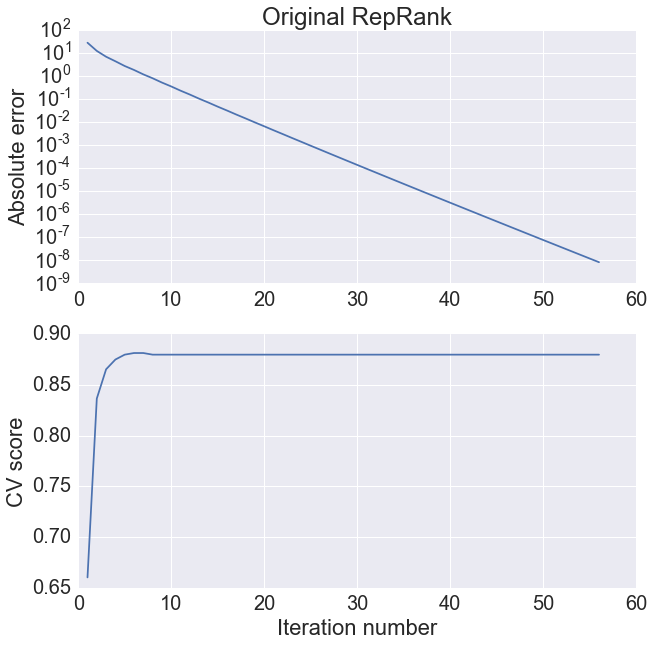

In [20]:
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
plt.subplot(211)

plt.plot(np.arange(1, len(err) + 1), np.array(err))
plt.title("Original RepRank")
plt.ylabel("Absolute error")
plt.yscale("log")

plt.subplot(212)

plt.plot(np.arange(1, len(cv_score) + 1), np.array(cv_score))
plt.ylabel("CV score")
plt.xlabel("Iteration number")

#plt.show()
plt.savefig('1.png')

In [21]:
# performance of original RepRank

tt = np.empty(100)

for i in range(len(tt)):
    begin = time.time()
    k, ans = RepRank(F, B, d)
    end = time.time()
    tt[i] = end - begin
    
print("Average time spent: {}\nVariance : {}".format(str(np.mean(tt)), str(np.std(tt, ddof=1))))

Average time spent: 2.09280740738
Variance : 0.386052306915


In [22]:
def Anderson(F, B, d, depth=5, maxiter=200, x0=None, tol=1e-8, callback=None):
    if x0 is None:
        x0 = d.copy()
    else:
        x0 = x0.copy()

    Xk = [x0, T(F, B, d, x0)]
    Gk = [Xk[1].copy(), T(F, B, d, Xk[1])]
    Fk = [Gk[0] - Xk[0], Gk[1] - Xk[1]]
    Q = np.empty((depth + 1, depth + 1))
    Q[0:2, 0:2] = np.array([[np.dot(Fk[0], Fk[0]), np.dot(Fk[0], Fk[1])],
                            [np.dot(Fk[1], Fk[0]), np.dot(Fk[1], Fk[1])]])

    for k in range(maxiter):
        mk = min(depth, k + 1)
        alpha = np.linalg.solve(Q[0:(mk + 1), 0:(mk + 1)], np.ones(mk + 1))
        alpha /= alpha.sum()
        x_next = alpha[mk] * Gk[mk].copy()
        for i in range(mk):
            x_next += alpha[i] * Gk[i]
        g_next = T(F, B, d, x_next)
        f_next = g_next - x_next
        n = np.linalg.norm(f_next)
        if callback is not None:
            callback(x_next, n)
        if n < tol:
            break
        if mk == depth:
            Xk.pop(0)
            Gk.pop(0)
            Fk.pop(0)
        Xk.append(x_next)
        Gk.append(g_next)
        Fk.append(f_next)
        if mk == depth:
            Q[:depth, :depth] = Q[1:(depth + 1), 1:(depth + 1)]
            for i in range(depth):
                Q[depth][i] = Q[i][depth] = np.dot(f_next, Fk[i])
            Q[depth][depth] = n ** 2
        else:
            for i in range(mk + 1):
                Q[mk + 1][i] = Q[i][mk + 1] = np.dot(f_next, Fk[i])
            Q[mk + 1][mk + 1] = n ** 2

    ans = x_next.copy()
    return(k + 1, ans.reshape(-1,))

In [23]:
# RepRank with Anderson acceleration answer

k, ans = Anderson(F, B, d)
print("Required numeber of iterations for RepRank with Anderson acceleration: {}.".format(str(k)))

for i in list(map(i2t.get, ans.argsort(axis=0)[::-1][:3].tolist())):
    webbrowser.open_new_tab("https://twitter.com/intent/user?user_id={}".format(str(i)))

for i in list(map(i2t.get, ans.argsort(axis=0)[::-1][-3:].tolist())):
    webbrowser.open_new_tab("https://twitter.com/intent/user?user_id={}".format(str(i)))

Required numeber of iterations for RepRank with Anderson acceleration: 33.


In [24]:
# cross-validation of RepRank with Anderson acceleration

err = []
cv_score = []
k, ans = Anderson(F, B, d_CV, callback=check_cv_err)

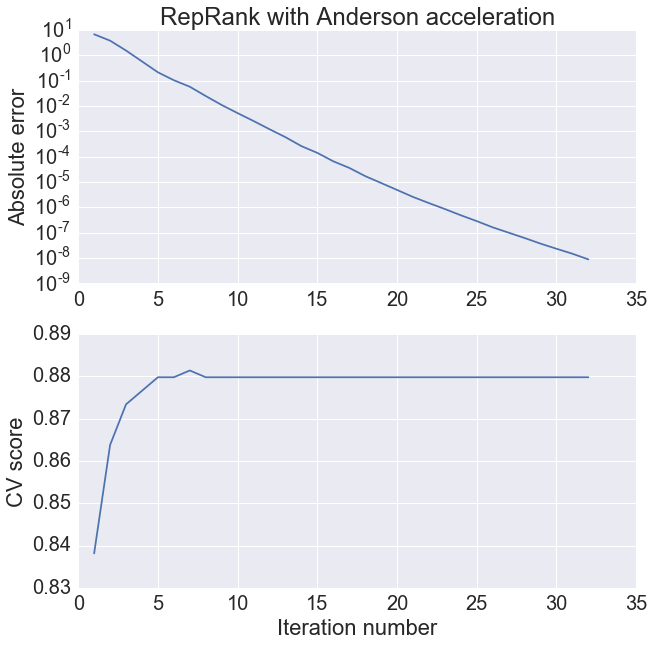

In [26]:
plt.figure(figsize=(10,10))
plt.subplot(211)

plt.plot(np.arange(1, len(err) + 1), np.array(err))
plt.title("RepRank with Anderson acceleration")
plt.ylabel("Absolute error")
plt.yscale("log")
#plt.grid()

plt.subplot(212)

plt.plot(np.arange(1, len(cv_score) + 1), np.array(cv_score))
plt.ylabel("CV score")
plt.xlabel("Iteration number")
#plt.grid()

plt.savefig('2.png')
#plt.show()

In [37]:
time_mean_AA = np.empty(10)
time_var_AA = np.empty(10)

for i in range(10):
    print(i)
    tt = np.empty(100)
    for j in range(100):
        begin = time.time()
        k, ans = Anderson(F, B, d, depth=(i + 1))
        end = time.time()
        tt[j] = end - begin
    time_mean_AA[i] = np.mean(tt)
    time_var_AA[i] = np.std(tt, ddof=1)

0
1
2
3
4
5
6
7
8
9


In [39]:
print("Average time spent Anderson: {}\nVariance : {}".format(str(np.mean(tt)), str(np.std(tt, ddof=1))))

Average time spent Anderson: 1.84924129248
Variance : 0.501644879084


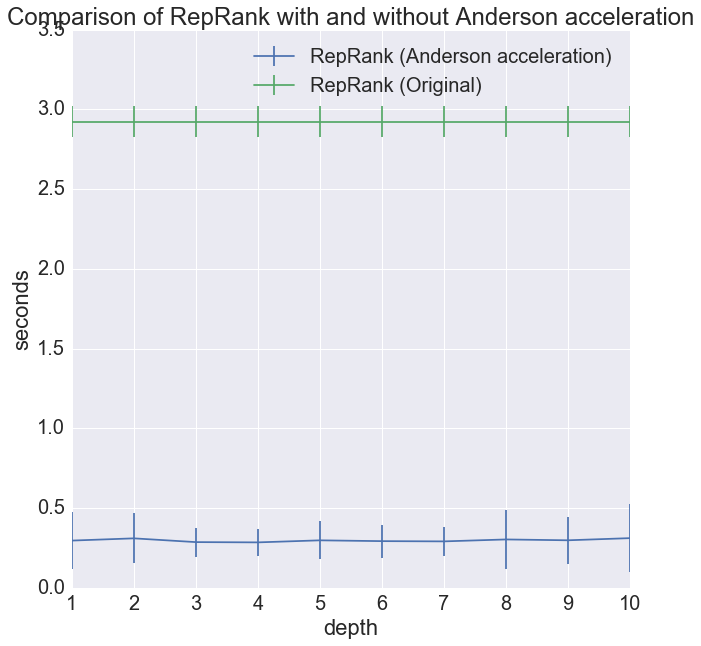

In [47]:
plt.figure(figsize=(10,10))
plt.errorbar(np.arange(1, 11), time_mean_AA, yerr=time_var_AA * 3, label="RepRank (Anderson acceleration)")
plt.errorbar(np.arange(1, 11), np.ones(10) * 2.9226971674, yerr=0.0320703981146 * 3, label="RepRank (Original)")



plt.legend(loc='best')
plt.xlabel("Depth")
plt.ylabel("Seconds")
plt.title("Comparison of RepRank with and without Anderson acceleration")
plt.savefig('3.png')

## Now Let's relax our abs. error threshold

In [41]:
# performance of original RepRank

tt = np.empty(100)

for i in range(len(tt)):
    begin = time.time()
    k, ans = RepRank(F, B, d, tol=0.1, maxiter=10)
    end = time.time()
    tt[i] = end - begin
    
print("Average time spent: {}\nVariance : {}".format(str(np.mean(tt)), str(np.std(tt, ddof=1))))

Average time spent: 0.403882670403
Variance : 0.144182882953


In [42]:
time_mean_AA = np.empty(10)
time_var_AA = np.empty(10)

for i in range(10):
    tt = np.empty(100)
    for j in range(100):
        begin = time.time()
        k, ans = Anderson(F, B, d, depth=(i + 1), tol=0.1, maxiter=5)
        end = time.time()
        tt[j] = end - begin
    time_mean_AA[i] = np.mean(tt)
    time_var_AA[i] = np.std(tt, ddof=1)

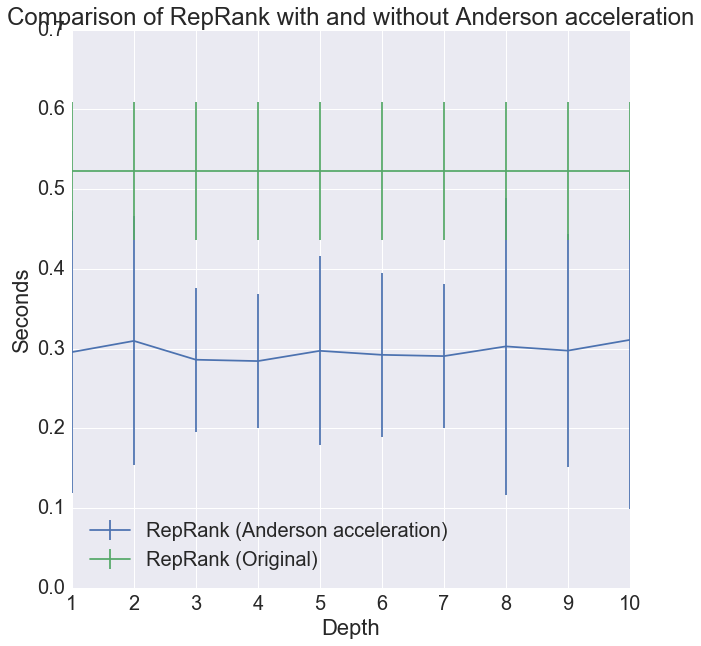

In [46]:
plt.figure(figsize=(10,10))

plt.errorbar(np.arange(1, 11), time_mean_AA, yerr=time_var_AA * 3, label="RepRank (Anderson acceleration)")
plt.errorbar(np.arange(1, 11), np.ones(10) * 0.522669894695, yerr=0.028686796305 * 3, label="RepRank (Original)")

plt.legend(loc='best')
plt.xlabel("Depth")
plt.ylabel("Seconds")
plt.title("Comparison of RepRank with and without Anderson acceleration")
plt.savefig('4.png')